In [1]:
#copy from llm_plot3 :
# we cut after 6''
# will need to explain that

# reworked from llm_plot4_cut_agree, merged with 
# study_llm_betterplot_Agree in step7_lenslightmodel


In [1]:
from Utils.tools import *
from astropy.io import fits
import matplotlib.pyplot as plt

from Data.conversion import conv_radec_to_xy,conv_xy_to_radec

from Data.input_data import load_fits
from Data.image_manipulation import load_fits,get_rotangle


In [2]:
#filt=str(sys.argv[1])
#filt="f475x"
fnt=27
plt.rcParams['xtick.labelsize'] = fnt
plt.rcParams['ytick.labelsize'] = fnt 
plt.rcParams['font.size'] = fnt
plt.rc('axes', labelsize=fnt)     # fontsize of the x and y labels
plt.rc('font', size=fnt)          # controls default text sizes
plt.rc('axes', titlesize=fnt)     # fontsize of the axes title
plt.rc('axes', labelsize=fnt)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=fnt)    # fontsize of the tick labels
plt.rc('ytick', labelsize=fnt)    # fontsize of the tick labels
plt.rc('legend', fontsize=fnt)    # legend fontsize

import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'
matplotlib.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'
matplotlib.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'

sett = get_setting_module("f814w_llm",1)
filt ="f814w"
FILT =filt.replace("f","F").replace("w","W").replace("x","X")


dir        = sett.data_path# FILT+"/llm_"+mod_name+"/"
lens_model = sett.lens_light_model_name_full#"model_tot_"+mod_name+".fits"
data = load_fits(dir+lens_model,HDU=-1)
    
param = ['a14','sb', 'flux_mean', 'flux_median', 'flux_mu', 
         'flux_mode','flux_iso','eps', 'eps_err','pa', 'pa_err',
         'x0', 'x0_err', 'y0', 'y0_err', 'a3', 'a3_err', 'b3', 'b3_err',
         'a4', 'a4_err','b4','b4_err']

param_new = ["x0","y0","a4","pa","eps","sb"]
y_ax      = ["$x_0-x_0(a=0)$","$y_0-y_0(a=0)$","a4/a","PA","$\epsilon$","SB"]
udm       = ["pix","pix","","$\degree$","","mag"]
titles    = ["Centre coordinate","Centre coordinate","Disky/boxyness parameter","Pointing angle","Ellipticity","Surface Brightness"]

In [3]:
from copy import copy


names_prm = ["eps","pa","x0","y0"]


param_names = data.names

cut  = 60
cut0 = 5
x0     = data.field("x0")[cut0:cut]
x0_err = data.field("x0_err")[cut0:cut]
y0     = data.field("y0")[cut0:cut]
y0_err = data.field("y0_err")[cut0:cut]
q      = 1-np.array(data.field("eps")[cut0:cut])
q_err  = np.array(data.field("eps_err")[cut0:cut])
trasnforM  = sett.transform_pix2angle
rotang     = get_rotangle(trasnforM)
phi  = (-np.array(data.field("pa")[cut0:cut])+ rotang) - 180 # fact -1 wrt DS9
if np.mean(phi)<-100:
    phi+=180
phi_err  = np.array(data.field("pa_err"))[cut0:cut]


center_xy = []
center_xy_err = []
for i,(x0i,y0i,err_x0i,err_y0i) in enumerate(zip(x0,y0,x0_err,y0_err)):
    ra,dec = conv_xy_to_radec(sett,x0i,y0i)
    center_xy.append([ra[0],dec[0]])
    ra_err  = np.sqrt((err_x0i*sett.pix_scale*np.cos(rotang*np.pi/90.))**2+(err_y0i*sett.pix_scale*np.sin(rotang*np.pi/90.))**2)
    dec_err = np.sqrt((err_x0i*sett.pix_scale*np.sin(rotang*np.pi/90.))**2+(err_y0i*sett.pix_scale*np.cos(rotang*np.pi/90.))**2)
    ra_err_,dec_err_  = err_x0i*sett.pix_scale,err_y0i*sett.pix_scale
    center_xy_err.append([ra_err,dec_err])
r14 = data.field("a14")[cut0:cut]



In [4]:

def coordinate_arrows(ax, sett,frame_size,image_size, color='w', font_size=20, arrow_size=0.05):
    d = frame_size
    d0 = d / 6.
    d1 = d / 15
    p0 = d / 50
    pt = d / 22

    deltaPix = frame_size/image_size
    ra0, dec0 = conv_xy_to_radec(sett,(d - d0) / deltaPix, d1 / deltaPix) 
    ra0 , dec0 = ra0[0],dec0[0]
    xx_, yy_ = conv_radec_to_xy(sett,ra0, dec0)
    xx_,yy_ = xx_[0],yy_[0]
    xx_ra, yy_ra = conv_radec_to_xy(sett,ra0 + p0, dec0)
    xx_ra,yy_ra = xx_ra[0],yy_ra[0]
    xx_dec, yy_dec = conv_radec_to_xy(sett,ra0, dec0 + p0)
    xx_dec,yy_dec = xx_dec[0],yy_dec[0]
    xx_ra_t, yy_ra_t = conv_radec_to_xy(sett,ra0 + pt, dec0)
    xx_ra_t,yy_ra_t = xx_ra_t[0], yy_ra_t[0]
    xx_dec_t, yy_dec_t = conv_radec_to_xy(sett,ra0, dec0 + pt)
    xx_dec_t, yy_dec_t =  xx_dec_t[0], yy_dec_t[0] 
    deltaPix/=frame_size
    ax.arrow(xx_ * deltaPix, yy_ * deltaPix, (xx_ra - xx_) * deltaPix, (yy_ra - yy_) * deltaPix,
             head_width=arrow_size * d/frame_size/1.5, head_length=arrow_size * d/frame_size, fc=color, ec=color, linewidth=1)
    ax.text(xx_ra_t * deltaPix, yy_ra_t * deltaPix, "E", color=color, fontsize=font_size, ha='center')
    ax.arrow(xx_ * deltaPix, yy_ * deltaPix, (xx_dec - xx_) * deltaPix, (yy_dec - yy_) * deltaPix,head_width=arrow_size * d/frame_size/1.5, head_length=arrow_size * d/frame_size, fc=color, ec=color, linewidth=1)
    ax.text(xx_dec_t * deltaPix, yy_dec_t * deltaPix, "N", color=color, fontsize=font_size, ha='center')

def scale_bar(ax, sett,frame_size,image_size,dist=1.,  text='1"',color='w', font_size=23):
    d = frame_size
    p0 = d / 15.
    deltaPix = frame_size/image_size

    dist = (dist/sett.pix_scale)*deltaPix/frame_size
    ax.plot([p0/frame_size, p0/frame_size + dist], [p0/frame_size, p0/frame_size], linewidth=3, color=color)
    ax.text(p0/frame_size + dist / 2., p0/frame_size + 0.01 * d/frame_size, text, fontsize=font_size, color=color, ha='center')



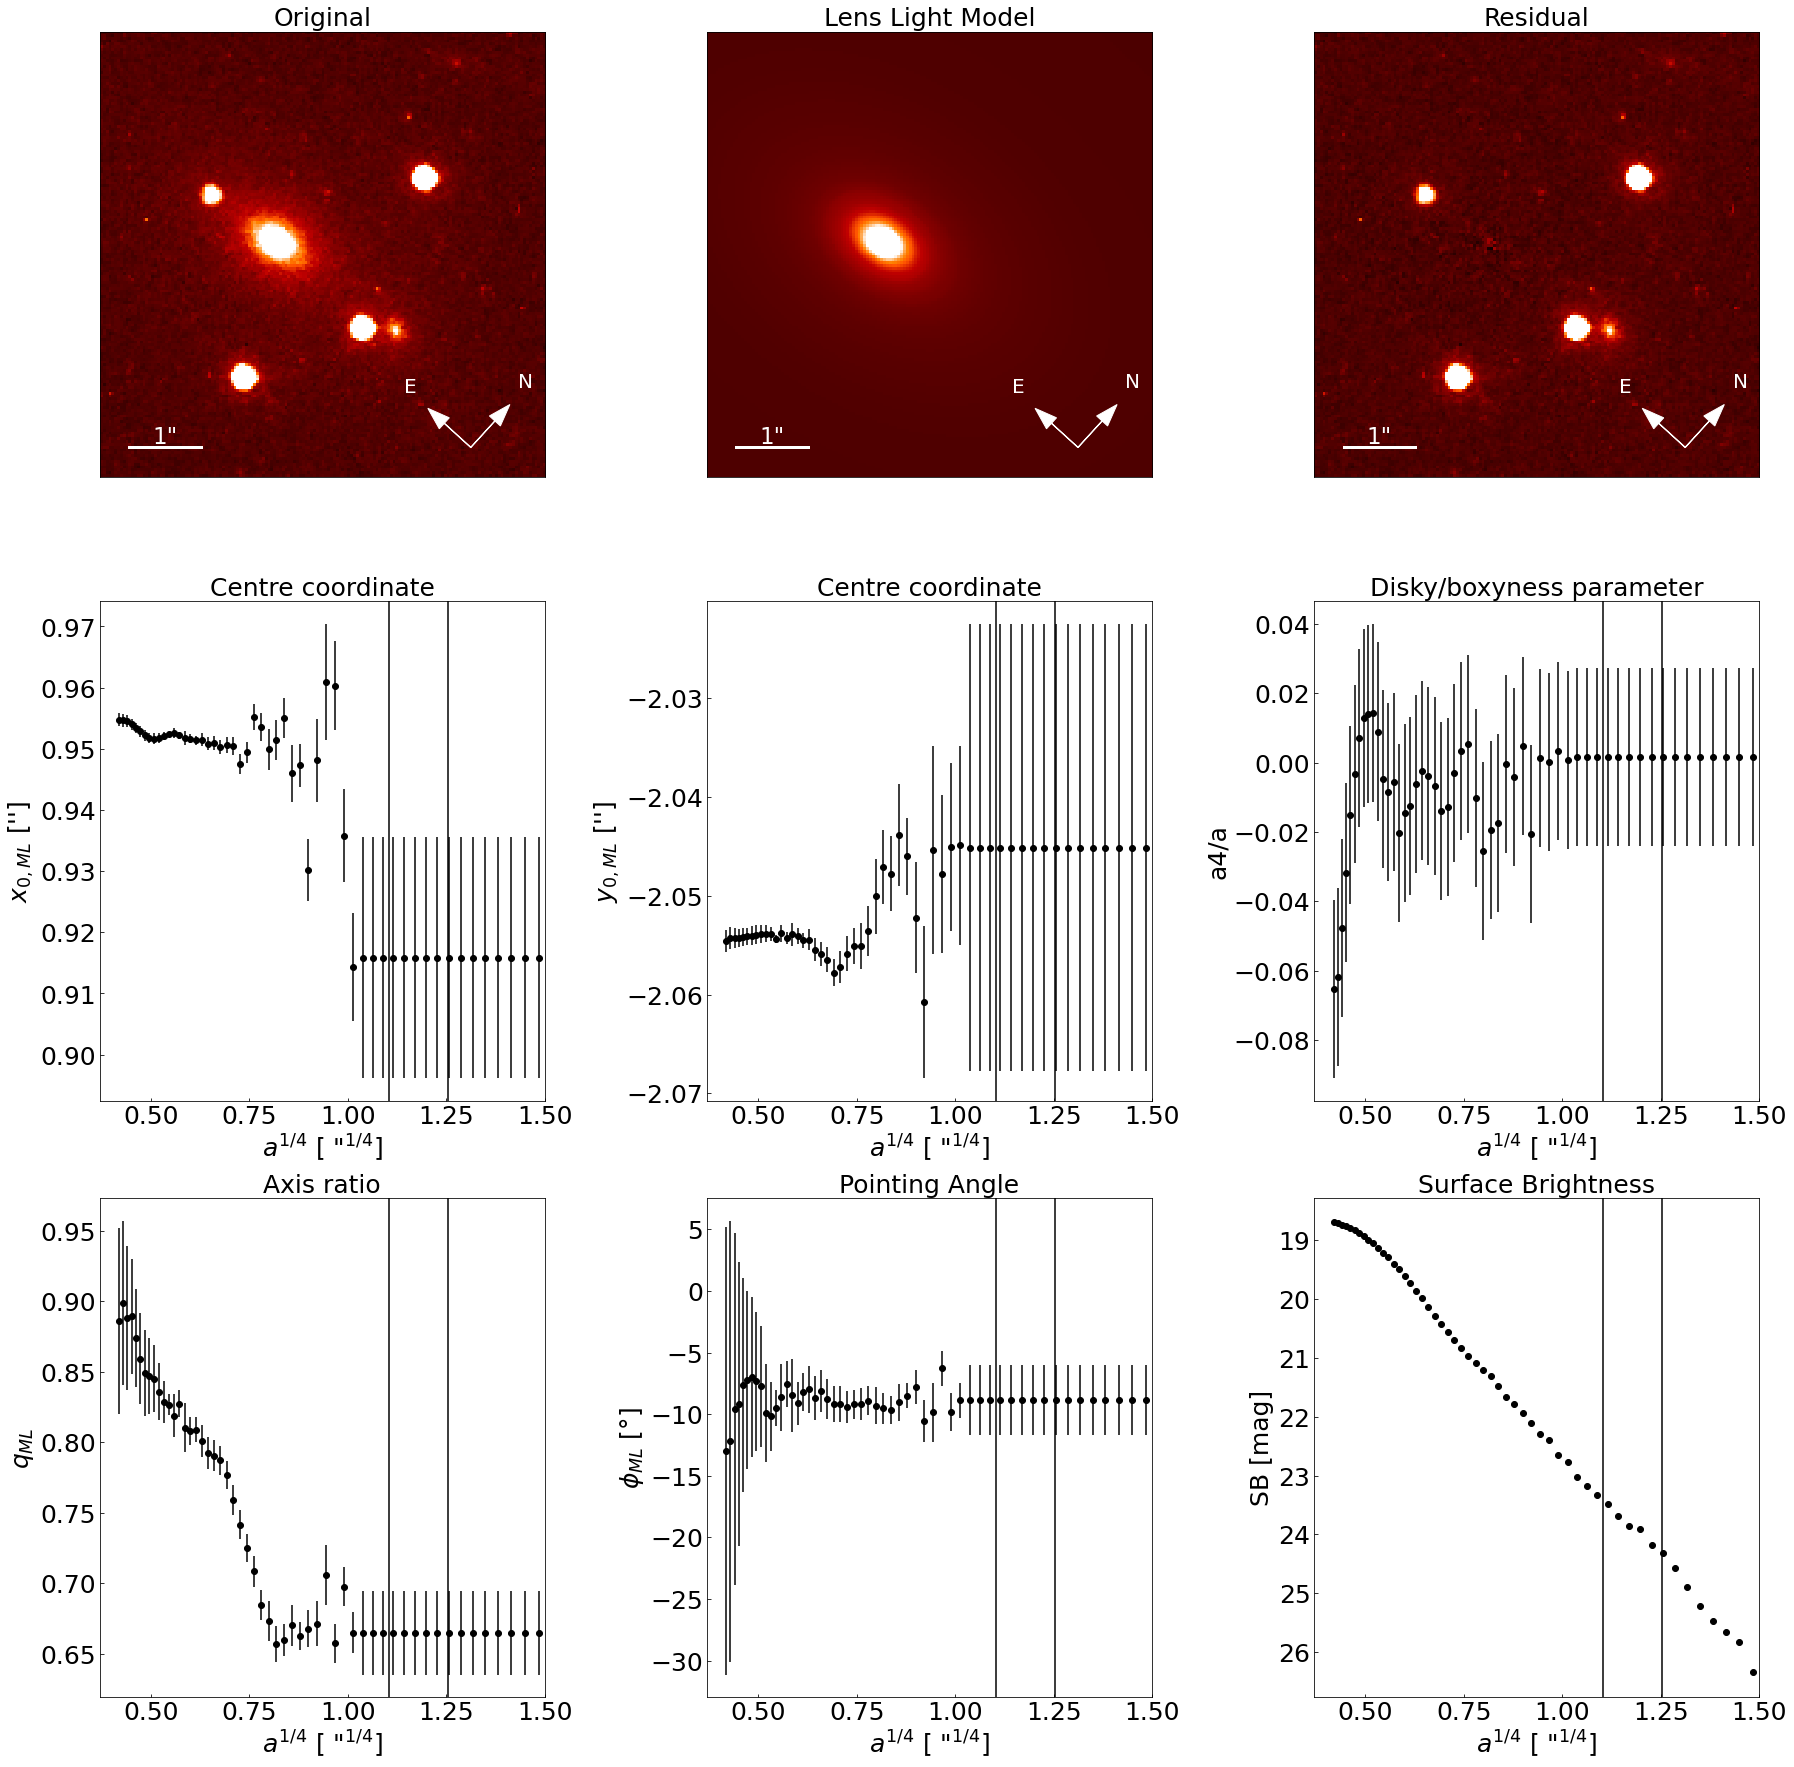

In [6]:
#figsize=(20,7)
fnt = 25
plt.rcParams['xtick.labelsize'] = fnt
plt.rcParams['ytick.labelsize'] = fnt 
plt.rcParams['font.size'] = fnt
plt.rc('axes', labelsize=fnt)     # fontsize of the x and y labels
plt.rc('font', size=fnt)          # controls default text sizes
plt.rc('axes', titlesize=fnt)     # fontsize of the axes title
plt.rc('axes', labelsize=fnt)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=fnt)    # fontsize of the tick labels
plt.rc('ytick', labelsize=fnt)    # fontsize of the tick labels
plt.rc('legend', fontsize=fnt)    # legend fontsize

fits_file = fits.open(dir+lens_model)
original = fits.open(dir+filt.replace("x","w")+"_lens_220527.fits")[0].data
model    = fits.open(dir+filt.replace("x","w")+"_llm_220527.fits")[0].data #same as [7]
if filt=="f814w":
    residual = fits.open(dir+"f814w_qso.fits")[0].data
else:
    residual = fits.open(dir+"f475w_qso_220527.fits")[0].data
 
figsize = (25,25)
f,axes= plt.subplots(3,3,figsize=figsize)
ax = axes[0][0]
vmin_im,vmax_im = -.05,.2
im = ax.matshow(original, origin='lower',vmin=vmin_im,vmax=vmax_im ,extent=[0, 1, 0, 1], 
                 cmap="gist_heat")

coordinate_arrows( ax,sett,frame_size=figsize[0],image_size=len(residual),color="w") 
scale_bar( ax,sett,frame_size=figsize[0],image_size=len(residual))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.autoscale(False)
ax.set_title("Original")

ax = axes[0][1]
im = ax.matshow(model, origin='lower',vmin=vmin_im,vmax=vmax_im,extent=[0, 1, 0, 1], 
                 cmap="gist_heat")
coordinate_arrows( ax,sett,frame_size=figsize[0],image_size=len(residual),color="w") 
scale_bar( ax,sett,frame_size=figsize[0],image_size=len(residual))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.autoscale(False)
ax.set_title("Lens Light Model")

ax = axes[0][2]
im = ax.matshow(residual, origin='lower',vmin=vmin_im,vmax=vmax_im,extent=[0, 1, 0, 1], 
                 cmap="gist_heat")
coordinate_arrows( ax,sett,frame_size=figsize[0],image_size=len(residual),color="w") 
scale_bar( ax,sett,frame_size=figsize[0],image_size=len(residual))

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.autoscale(False)
ax.set_title("Residual")


from Plots.plotting_tools import base_colors as color
absmin_r14 = np.min([np.min(l)  for l in list(r14)])
max_x = 1.5

qphi,titl = q,r"$q_{ML}$" 


c="k"
axes[2][0].scatter(r14, qphi,color="k")
axes[2][0].errorbar(r14, qphi, yerr=q_err, fmt="none",ecolor="k")
#axes[2][0].set_ylim(0,1.15)
axes[2][0].set_title("Axis ratio") 
axes[2][0].set_ylabel(titl)
axes[2][0].set_xlabel(r'$a^{1/4}$ [ "'+r'$^{1/4}]$')
axes[2][0].set_xlim(absmin_r14-.05,max_x)
qphi,titl =phi,r"$\phi_{ML}$"

axes[2][1].scatter(r14, qphi,color=c)
axes[2][1].errorbar(r14, qphi, yerr=phi_err, fmt="none",ecolor=c)
 
axes[2][1].set_xlim(absmin_r14-.05,max_x)
#axes[2][1].set_ylim(-50,50) 
axes[2][1].set_title("Pointing Angle")
axes[2][1].set_xlabel(r'$a^{1/4}$ [ "'+r'$^{1/4}]$')
axes[2][1].set_ylabel(titl+r" [$\degree$]")
axes[2][1].set_xlim(absmin_r14-.05,max_x)


axes[1][0].set_xlabel(r'$a^{1/4}$ [ "'+r'$^{1/4}]$')
xx = np.transpose(center_xy)[0]
axes[1][0].scatter(r14, xx,color=c)
axes[1][0].errorbar(r14,xx, yerr=np.transpose(center_xy_err)[0], fmt="none",ecolor=c)

#axes[1][0].set_ylim(np.mean(xx[i])-5*np.std(xx[i]),np.mean(xx[i])+5*np.std(xx[i]) )
axes[1][0].set_xlim(absmin_r14-.05,max_x)

titl=r"$x_{0,ML}$"
axes[1][0].set_ylabel(titl+ r" ['']")
axes[1][0].set_title("Centre coordinate")



yy = np.transpose(center_xy)[1]

axes[1][1].scatter(r14, yy,color=c)
axes[1][1].set_xlabel(r'$a^{1/4}$ [ "'+r'$^{1/4}]$')

axes[1][1].errorbar(r14, yy, yerr=np.transpose(center_xy_err)[1], fmt="none",ecolor=c)
#axes[1][1].set_ylim(np.mean(yy)-5*np.std(yy),np.mean(yy)+5*np.std(yy) )
axes[1][1].set_xlim(absmin_r14-.05,max_x)
axes[1][1].set_ylabel(r"$y_{0,ML}$ ['']")
axes[1][1].set_title("Centre coordinate")


a4 = data["a4"][cut0:cut]
a4_err = data["a4_err"][cut0:cut]
axes[1][2].scatter(r14, a4,color=c)
axes[1][2].set_xlabel(r'$a^{1/4}$ [ "'+r'$^{1/4}]$')
axes[1][2].errorbar(r14, a4, yerr=np.transpose(a4_err)[1], fmt="none",ecolor=c)
axes[1][2].set_xlim(absmin_r14-.05,max_x)
axes[1][2].set_ylabel(r"a4/a")
axes[1][2].set_title("Disky/boxyness parameter")
    


sb = []
for k in np.array(data["sb"][cut0:cut]):
    if math.isnan(k)==False and math.isinf(k)==False:
        sb.append(k)
axes[2][2].scatter(r14, sb,color=c)
axes[2][2].set_xlabel(r'$a^{1/4}$ [ "'+r'$^{1/4}]$')
#axes[2][2].errorbar(r14, sb, yerr=np.transpose(sb_err)[1], fmt="none",ecolor=c)
axes[2][2].set_xlim(absmin_r14-.05,max_x)
axes[2][2].set_ylabel(r"SB [mag]")
axes[2][2].set_title("Surface Brightness")
axes[2][2].set_ylim(np.nanmax(sb)+0.4,np.nanmin(sb)-0.4 )
    


for i in range(len(axes)):
    for j in range(len(axes[i])):
        axes[i][j].tick_params(direction="in")
        if i!=0:
            axes[i][j].axvline(1.10297439,c="k")
            axes[i][j].axvline(1.253897731,c="k")


plt.tight_layout(pad=.4) 
#plt.tight_layout()
plt.savefig("study_llm_240423.pdf")
#plt.savefig("/home/jackquei/Desktop/UNI_Muenchen/Thesis/Article/images/lens_light_model_agree.pdf")
plt.show()



In [87]:
#############################################################
# here we compare the different Isophotal Lens Light fits   #
# in the various filters and obtain a common prior          #
#############################################################

# this info might be better implemented in all the settings files
dir    = "/home/jackquei/Desktop/UNI_Muenchen/Thesis/steps/step7_lenslightmodel/models_params/" 

models = ["isopy_f475w_220525.fits","model_tot_f814w_220527.fits","isopy_F105W_corr_250823.fits",\
          "new2_outdata_model_f140w.fits","model_tot_f160w_030423.fits"]
def find_filter(str_fits):
    filt=""
    k=None
    for a in str_fits:
        if a=="f" or a=="F":
            k=0
            filt+=a
        elif k is not None:
            k+=1
            filt+=a
        if k==4 :
            if a=="w" or a=="x" or a=="W" or a=="X":
                break
    return filt



1.0378530187978565

In [ ]:
center_xy = {}
q         = {}  #!! q is axis ratio, not ellipticity
phi       = {}
r14       = {}
names_prm = ["eps","pa","x0","y0"]
filters = []
for mod in models:
    image_path  = dir+mod
    param_val   = load_fits(image_path,HDU=-1)
    param_names = param_val.names
    filt = find_filter(mod)
    sett = get_setting_module(filt,1)
    
    cut  = 60
    cut0 = 5
    x0     = param_val.field("x0")[cut0:cut]
    x0_err = param_val.field("x0_err")[cut0:cut]
    y0     = param_val.field("y0")[cut0:cut]
    y0_err = param_val.field("y0_err")[cut0:cut]
    q[filt] = 1-np.array(param_val.field("eps")[cut0:cut])
    q["err_"+filt] = np.array(param_val.field("eps_err")[cut0:cut])
    trasnforM  = sett.transform_pix2angle
    rotang     = get_rotangle(trasnforM)
    phi[filt]  = (-np.array(param_val.field("pa")[cut0:cut])+ rotang) - 180 # fact -1 wrt DS9
    if np.mean(phi[filt])<-100:
        phi[filt]+=180
    phi["err_"+filt]  = np.array(param_val.field("pa_err"))[cut0:cut]
    
    
    center_xy[filt] = []
    center_xy["err_"+filt] = []
    for i,(x0i,y0i,err_x0i,err_y0i) in enumerate(zip(x0,y0,x0_err,y0_err)):
        ra,dec = conv_xy_to_radec(sett,x0i,y0i)
        if abs(dec[0])>10:
            print(sett)
        #radec,_,_ = conv_general([sett.x_im_pix[0],sett.y_im_pix[0]], [[x0i,y0i]] ,sett.transform_pix2angle,[sett.ra_at_xy_0,sett.dec_at_xy_0])
        center_xy[filt].append([ra[0],dec[0]])
        #err_radec = conv_pix_to_radec_err([sett.x_im_pix[0],sett.y_im_pix[0]], [[x0i,y0i],[err_x0i,err_y0i]],
        #                                  sett.transform_pix2angle,[sett.ra_at_xy_0,sett.dec_at_xy_0])
        ra_err  = np.sqrt((err_x0i*sett.pix_scale*np.cos(rotang*np.pi/90.))**2+(err_y0i*sett.pix_scale*np.sin(rotang*np.pi/90.))**2)
        dec_err = np.sqrt((err_x0i*sett.pix_scale*np.sin(rotang*np.pi/90.))**2+(err_y0i*sett.pix_scale*np.cos(rotang*np.pi/90.))**2)
        ra_err_,dec_err_  = err_x0i*sett.pix_scale,err_y0i*sett.pix_scale
        center_xy["err_"+filt].append([ra_err,dec_err])
    r14[filt] = param_val.field("a14")[cut0:cut]
    filters.append(filt)

In [ ]:
mod = "isopy_f475w_220525.fits"
image_path  = dir+mod
param_val   = load_fits(image_path,HDU=-1)
param_names = param_val.names
filt = find_filter(mod)
sett = get_setting_module(filt,1)
x0     = param_val.field("x0")[1:]
y0     = param_val.field("y0")[1:]
x0[10],y0[10],conv_xy_to_radec(sett,x0[10],y0[10])
xi,yi = conv_xy_to_radec(sett,x0[10],y0[10])
xi,yi = xi[0],yi[0] 

In [ ]:
mod = models[0] 
image_path  = dir+mod
param_val   = load_fits(image_path,HDU=-1)
param_names = param_val.names
filt = find_filter(mod)
sett = get_setting_module(filt,1)
x0     = param_val.field("x0")[1:]
 

In [ ]:
# Test 

def frompointtolenght(arr,i):
    dx,dy = arr
    dxy = np.sqrt(dx**2+dy**2)
    return dxy/get_setting_module(filters[i],1).pix_scale
print("distance of center in pixel btw the different filters wrt f814")
print([frompointtolenght(np.mean(center_xy[filters[i]][1:40],axis=0) -np.mean(center_xy[filters[0]][1:40],axis=0),i)  for i in 
       range(len(filters[1:]))])#, [np.round((r14[f]**4)/get_setting_module(filt,1).pix_scale,4) for f in filters]
#dxy = np.abs(np.array(center_xy["f475w"])-np.array([0.998697002926261, -2.027591894231689]))
#np.where(dxy==0
#center_xy["f475w"][:40],center_xy["f475w"][40:]

i_fix_a14 = []
for i in filters:
    dxy = np.abs(np.array(center_xy[i])-np.array(center_xy[i][-1]))
    i_fix = np.where(dxy==0)[0].min()
    print(i_fix)
    i_fix_a14.append(i_fix)

np.mean([np.mean(center_xy[filters[i]][1:i_fix_a14[i]],axis=0) for i in range(len(filters))],axis=0)

In [ ]:
def dist(xi,yi,xj,yj):
    return np.sqrt((xi-xj )**2 + (yi-yj)**2)

avrg_xy_c = np.mean([np.mean(center_xy[filters[i]][1:i_fix_a14[i]],axis=0) for i in range(len(filters))],axis=0)

def find_minmax():
    min__,max__ = [],[]
    for f in filters:
        sett = get_setting_module(f,1)
        xim,yim = sett.x_image,sett.y_image
        
        #xc,yc =np.mean(center_xy[filters[]],axis=0)
        xc,yc = np.mean([np.mean(center_xy[filters[i]][1:i_fix_a14[i]],axis=0) for i in range(len(filters))],axis=0)
        dists = [ dist(xi,yi,xc,yc) for xi,yi in zip(xim,yim)]
        min_ = np.min(dists)
        max_ = np.max(dists)
        min__.append(min_)
        max__.append(max_)
    return min(min__),max(max__) 

def find_r14minmax():
    return np.array(find_minmax())**(1/4.) 

In [ ]:

absmin_r14 = np.min([np.min(l)  for l in list(r14.values())])
max_x = 1.5
min_r14,max_r14 = find_r14minmax()
#color = ["r","b","g","y","k"]
from Plots.plotting_tools import base_colors as color
fig,ax = plt.subplots(2,2,figsize=(17,15)) 
for i,c in enumerate(color):
    if c=="k" or c=="black":
        color[i]="grey"
    if c=="b":
        color[i]="cyan"
qphi,titl = q,r"$q_{ML}$" 
mean_i = []
for flt,c in zip(filters,color):

    ax[0][0].scatter(r14[flt], qphi[flt],color=c,label=flt.upper())
    ax[0][0].errorbar(r14[flt], qphi[flt], yerr=qphi["err_"+flt], fmt="none",ecolor=c)
    index_r = np.where((r14[flt]>min_r14)&(r14[flt]<max_r14))

    ax[0][0].axvline(min_r14,c="grey")
    if c==color[-1]:
        ax[0][0].axvline(max_r14,c="grey",label="Images range")
    else:
        ax[0][0].axvline(max_r14,c="grey")
    for qphi_i in qphi[flt][index_r]:
        mean_i.append(qphi_i)
    ax[0][0].set_xlim(absmin_r14-.05,max_x)

ax[0][0].set_ylim(0,1.15)
ax[0][0].set_title("Axis ratio")
ax[0][0].axhline(np.mean(mean_i))
ax[0][0].set_ylabel(titl)
ax[0][0].set_xlabel(r'$a^{1/4}$ [ "'+r'$^{1/4}]$')
ax[0][0].legend(loc="lower left")

qphi,titl =phi,r"$\phi_{ML}$"

mean_i = []
for flt,c in zip(filters,color):
    ax[0][1].scatter(r14[flt], qphi[flt],color=c,label=flt)
    ax[0][1].errorbar(r14[flt], qphi[flt], yerr=qphi["err_"+flt], fmt="none",ecolor=c)
    index_r = np.where((r14[flt]>min_r14)&(r14[flt]<max_r14))

    ax[0][1].axvline(min_r14,c="grey")
    ax[0][1].axvline(max_r14,c="grey")
    for qphi_i in qphi[flt][index_r]:
        mean_i.append(qphi_i)
    ax[0][1].set_xlim(absmin_r14-.05,max_x)
ax[0][1].set_ylim(-50,50)
ax[0][1].axhline(np.mean(mean_i),label="Mean")
#ax[0][1].set_title(titl)
ax[0][1].set_title("Pointing Angle")
ax[0][1].set_xlabel(r'$a^{1/4}$ [ "'+r'$^{1/4}]$')
ax[0][1].set_ylabel(titl+r" [$\degree$]")

xx,yy = [],[]
xx_flat,yy_flat = [],[]
xx_err,yy_err = [],[]
for flt,c in zip(filters,color):
    only_inside = np.where(r14[flt]<min_r14)
    x_inside,y_inside = np.transpose(np.array(center_xy[flt])[only_inside])
    x,y = np.transpose(np.array(center_xy[flt]))
    x_err,y_err = np.transpose(np.array(center_xy["err_"+flt]))
    xx.append(x) 
    yy.append(y)
    for xi,yi in zip(x_inside,y_inside):
        xx_flat.append(xi)
        yy_flat.append(yi)
    xx_err.append(x_err)
    yy_err.append(y_err)
mean_x = [np.mean(xx_flat),np.std(xx_flat)]
mean_y = [np.mean(yy_flat),np.std(yy_flat)]

for i,(flt,c) in enumerate(zip(filters,color)):
    ax[1][0].axvline(min_r14,c="grey")
    ax[1][0].axvline(max_r14,c="grey")
    ax[1][0].set_xlabel(r'$a^{1/4}$ [ "'+r'$^{1/4}]$')

    ax[1][0].scatter(r14[flt], xx[i],color=c,label=flt)
    ax[1][0].errorbar(r14[flt], xx[i], yerr=xx_err[i], fmt="none",ecolor=c)
    if i==0:
        ax[1][0].set_ylim(np.mean(xx[i])-5*np.std(xx[i]),np.mean(xx[i])+5*np.std(xx[i]) )
    ax[1][0].set_xlim(absmin_r14-.05,max_x)

ax[1][0].axhline(mean_x[0])
titl=r"$x_{0,ML}$"
ax[1][0].set_ylabel(titl+ r" ['']")
ax[1][0].set_title("Centre coordinate")


for i,(flt,c) in enumerate(zip(filters,color)):
    ax[1][1].axvline(min_r14,c="grey")
    ax[1][1].axvline(max_r14,c="grey")
    ax[1][1].scatter(r14[flt], yy[i],color=c,label=flt)
    ax[1][1].set_xlabel(r'$a^{1/4}$ [ "'+r'$^{1/4}]$')

    ax[1][1].errorbar(r14[flt], yy[i], yerr=yy_err[i], fmt="none",ecolor=c)
    if i==0:
        ax[1][1].set_ylim(np.mean(yy[i])-5*np.std(yy[i]),np.mean(yy[i])+5*np.std(yy[i]) )
    ax[1][1].set_xlim(absmin_r14-.05,max_x)
titl=r"$y_{c,LL}$"

ax[1][1].axhline(mean_y[0])
#ax[1][1].set_title(titl)

ax[1][1].set_ylabel(r"$y_{0,ML}$ ['']")
ax[1][1].set_title("Centre coordinate")

for i in range(len(ax)):
    for j in range(len(ax[i])):
        ax[i][j].tick_params(direction="in")
#plt.tight_layout()
plt.tight_layout(pad=1) 
#plt.savefig("study_llm_240423.pdf")
plt.savefig("study_llm_011023.pdf")
plt.show()

In [ ]:
mean_qphi = []
for qphi in [q,phi] :
    mean_i = []
    for flt in filters:
        index_r = np.where((r14[flt]>min_r14)&(r14[flt]<max_r14))        
        for qphi_i in qphi[flt][index_r]:
            mean_i.append(qphi_i)
    mean_qphi.append([np.mean(mean_i),np.std(mean_i)])

results = {"q":[*mean_qphi[0]],
           "phi":[*mean_qphi[1]],
           "x":mean_x,
          "y":mean_y}
pickle_results(res=results,name="LLM_results_230825",savefig_path="./data/.")

udm =   [r" [\, ]",r" [$^\circ$]",r" ['']",r" ['']"]
for udmi,r in zip(udm,results):
    print(r"$\langle"+r+"_{LL}\rangle$ ",udmi,"&",np.round(results[r][0],2),r"$\pm$",np.round(results[r][1],2),r"\\")